# **Librerias**

In [127]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import os
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score, precision_score,roc_auc_score
from sklearn.model_selection import KFold

In [82]:
pathDatos = Path("..") / "datos"
pathDatos

WindowsPath('../datos')

# **Lectura de Datos**

In [83]:
dfAtributos = pd.read_csv(os.path.join(pathDatos,'atributos.csv'), index_col=[0]).reset_index(drop=True)
print(f'El tamaño del conjunto de datos es:',dfAtributos.shape)

El tamaño del conjunto de datos es: (4400, 9)


In [84]:
dfTrx = pd.read_csv(os.path.join(pathDatos,'transacciones.csv'), index_col=[0]).reset_index(drop=True)
print(f'El tamaño del conjunto de datos es:',dfTrx.shape)

El tamaño del conjunto de datos es: (280828, 5)


In [85]:
dfTrx.dtypes

ACCOUNT_ID            int64
SKU_ID                int64
INVOICE_DATE          int64
ORDER_ID             object
ITEMS_PHYS_CASES    float64
dtype: object

In [86]:
dfAtributos.dtypes

POC                              int64
BussinessSegment                object
totalVolumen                   float64
SkuDistintosPromediosXOrden    float64
SkuDistintosToTales              int64
concentracion                   object
nse                             object
segmentoUnico                   object
canal                           object
dtype: object

# **_Unión de datos_**

In [87]:
df = dfTrx.merge(dfAtributos, left_on='ACCOUNT_ID', right_on='POC', how='inner')

In [88]:
df.shape

(278796, 14)

# EDA
**_Transformaciones de variables_**
- INVOICE_DATE: lo pasaremos a datetime

In [89]:
df['INVOICE_DATE'] = df['INVOICE_DATE'].apply(lambda row: datetime.strptime(str(row), "%Y%m%d"))

In [90]:
dfTrx.nunique()

ACCOUNT_ID           4535
SKU_ID                530
INVOICE_DATE           77
ORDER_ID            45547
ITEMS_PHYS_CASES      237
dtype: int64

In [91]:
df.head()

,ACCOUNT_ID,SKU_ID,INVOICE_DATE,ORDER_ID,ITEMS_PHYS_CASES,POC,BussinessSegment,totalVolumen,SkuDistintosPromediosXOrden,SkuDistintosToTales,concentracion,nse,segmentoUnico,canal
0,430606,7038,2022-07-29,512-3880249-0,100.0,430606,MediumUsage,326.49782,3.0000,34,Alto,Bajo,4.Activos,Mayorista
1,323267,14933,2022-07-29,512-3882307-0,1.0,323267,MinimalUsage,1.18812,5.0000,12,Medio,Medio,1.Inactivos,Kioscos/Maxikioscos
2,357825,21971,2022-07-23,512-3852880-0,8.0,357825,MediumUsage,112.64566,14.5455,56,Alto,Medio,NaN,KA Minoristas
3,444926,7038,2022-08-05,512-3913163-0,20.0,444926,MinimalUsage,65.26980,3.5263,14,Alto,Medio,2.Masivos,Mayorista
4,450771,7030,2022-08-16,512-3957000-0,5.0,450771,MediumUsage,209.26984,3.2222,17,Medio,Bajo,2.Masivos,Mayorista


In [92]:
def describe_datos(df):
  unicos =[]
  for col in df:
    unicos.append(df[col].unique())
  unicos = pd.Series(unicos, index=df.columns)
  descripcion = pd.concat([df.dtypes, df.isna().sum(),df.nunique(),unicos], axis=1)
  descripcion.columns = ['dtypes', 'null','nunique','unique' ]
  return(descripcion)

In [93]:
describe_datos(df)

,dtypes,null,nunique,unique
ACCOUNT_ID,int64,0,4379,"[430606, 323267, 357825, 444926, 450771, 17425..."
SKU_ID,int64,0,530,"[7038, 14933, 21971, 7030, 14191, 22461, 24880..."
INVOICE_DATE,datetime64[ns],0,77,"[2022-07-29 00:00:00, 2022-07-23 00:00:00, 202..."
ORDER_ID,object,0,45018,"[512-3880249-0, 512-3882307-0, 512-3852880-0, ..."
ITEMS_PHYS_CASES,float64,0,231,"[100.0, 1.0, 8.0, 20.0, 5.0, 70.0, 4.0, 7.0, 1..."
POC,int64,0,4379,"[430606, 323267, 357825, 444926, 450771, 17425..."
BussinessSegment,object,0,4,"[MediumUsage, MinimalUsage, HighUsage, PowerUs..."
totalVolumen,float64,0,4311,"[326.49782000000005, 1.1881199999999998, 112.6..."
SkuDistintosPromediosXOrden,float64,0,1573,"[3.0, 5.0, 14.5455, 3.5263, 3.2222, 8.05, 9.66..."
SkuDistintosToTales,int64,0,123,"[34, 12, 56, 14, 17, 100, 16, 112, 22, 60, 42,..."


In [94]:
# completamos las variables segmentoUnico y canal
df['segmentoUnico'].fillna(df['segmentoUnico'].mode()[0], inplace=True)
df['canal'].fillna(df['canal'].mode()[0], inplace=True)

**Hipotesis**
- Ciertos productos concentran el mayor número de compras.
- Los segmentos donde el perfil digital es alto, son también los que contran el mayor volumen de compras por lo que debemos enfocarnos en estos como clientes claves
- Identificar tendencias temporales, para identificar posibles periodos de promociones, eventos relevantes o actividad estacional

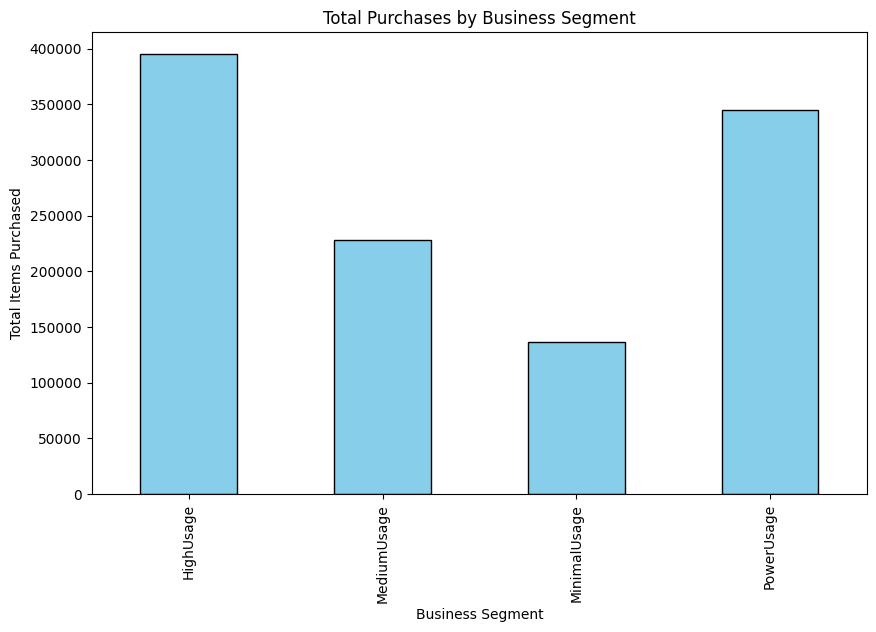

In [95]:
plt.figure(figsize=(10, 6))
df.groupby('BussinessSegment')['ITEMS_PHYS_CASES'].sum().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Purchases by Business Segment')
plt.xlabel('Business Segment')
plt.ylabel('Total Items Purchased')
plt.show()

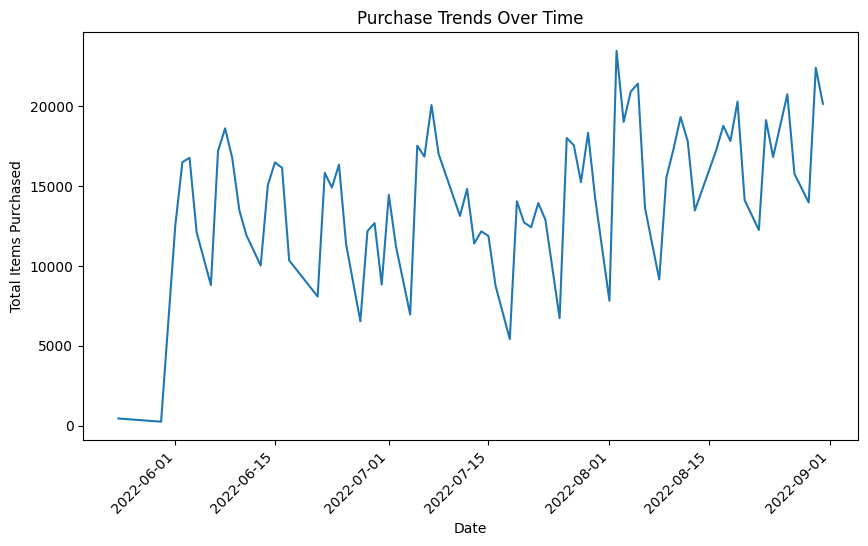

In [96]:
plt.figure(figsize=(10, 6))
df.groupby('INVOICE_DATE')['ITEMS_PHYS_CASES'].sum().plot()
plt.title('Purchase Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Total Items Purchased')
plt.xticks(rotation=45)
plt.show()

In [97]:
df_column = df['SKU_ID']
porcentaje = 80

frecuencia = df_column.value_counts()
sum_acumulada = (df_column.value_counts()/len(df)*100).cumsum().round(2)
pareto_df = pd.DataFrame({'Frecuencia':frecuencia,
                          'Porcentje_acumulado':sum_acumulada,
                          'Limite': porcentaje})
pareto_df[pareto_df['Porcentje_acumulado']<= porcentaje]

,Frecuencia,Porcentje_acumulado,Limite
SKU_ID,,,
7038,14553,5.22,80
19088,9815,8.74,80
7651,9727,12.23,80
24880,8815,15.39,80
19341,5788,17.47,80
...,...,...,...
24934,745,78.74,80
25184,730,79.00,80
16811,717,79.26,80


**_ de la oferta de productos 530, 93 de ellos concentran el 80% de las compras totales

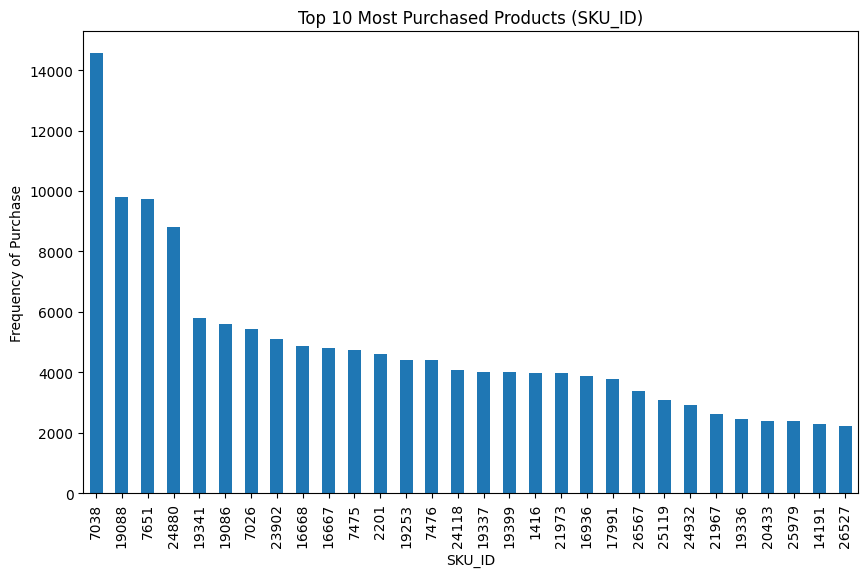

In [98]:
plt.figure(figsize=(10, 6))
df['SKU_ID'].value_counts().head(30).plot(kind='bar')
plt.title('Top 10 Most Purchased Products (SKU_ID)')
plt.xlabel('SKU_ID')
plt.ylabel('Frequency of Purchase')
plt.show()

# Ingenieria de variables

**Ingenieria de variables**
- generamos las siguientes variables por cliente - producto
- tratamos las variables categoricas mediante one - hot encoding 

In [99]:
df_cliente_prod = df.groupby(['ACCOUNT_ID', 'SKU_ID']).agg(
    total_quantity=('ITEMS_PHYS_CASES', 'sum'),
    avg_quantity=('ITEMS_PHYS_CASES', 'mean'),
    order_count=('ORDER_ID', 'nunique'),
    last_purchase=('INVOICE_DATE', 'max')
).reset_index()

df_cliente = df.groupby('ACCOUNT_ID').agg(
    total_items=('ITEMS_PHYS_CASES', 'sum'),
    unique_products=('SKU_ID', 'nunique'),
    avg_order_size=('ITEMS_PHYS_CASES', 'mean'),
    total_orders=('ORDER_ID', 'nunique')
).reset_index()

df_cliente_prod.shape, df_cliente.shape

((116001, 6), (4379, 5))

In [100]:
cols_cat = ['BussinessSegment', 'concentracion', 'nse', 'segmentoUnico', 'canal']
encoder = OneHotEncoder(handle_unknown='ignore')
cols_cat_encoded = encoder.fit_transform(df[cols_cat]).toarray()

encoded_categorical_df = pd.DataFrame(
    cols_cat_encoded,
    columns=encoder.get_feature_names_out(cols_cat),
    index=df.index
)


In [101]:

df_cliente_prod = df.groupby(['ACCOUNT_ID', 'SKU_ID']).agg(
    total_quantity=('ITEMS_PHYS_CASES', 'sum'),
    avg_quantity=('ITEMS_PHYS_CASES', 'mean'),
    order_count=('ORDER_ID', 'nunique'),
    last_purchase=('INVOICE_DATE', 'max')
).reset_index()

df_cliente = df.groupby('ACCOUNT_ID').agg(
    total_items=('ITEMS_PHYS_CASES', 'sum'),
    unique_products=('SKU_ID', 'nunique'),
    avg_order_size=('ITEMS_PHYS_CASES', 'mean'),
    total_orders=('ORDER_ID', 'nunique')
).reset_index()

In [ ]:
df['day_of_week'] = df['INVOICE_DATE'].dt.dayofweek
df['month'] = df['INVOICE_DATE'].dt.month


In [108]:
df[df['ACCOUNT_ID']==22204]

,ACCOUNT_ID,SKU_ID,INVOICE_DATE,ORDER_ID,ITEMS_PHYS_CASES,POC,BussinessSegment,totalVolumen,SkuDistintosPromediosXOrden,SkuDistintosToTales,concentracion,nse,segmentoUnico,canal,day_of_week,month
111242,22204,813,2022-07-12,102-39130554-0,1.0,22204,MediumUsage,0.12,2.0,2,Alto,Medio,4.Activos,COMIDA,1,7
188043,22204,7038,2022-06-28,102-39080265-0,1.0,22204,MediumUsage,0.12,2.0,2,Alto,Medio,4.Activos,COMIDA,1,6
198205,22204,25119,2022-06-28,102-39080265-0,1.0,22204,MediumUsage,0.12,2.0,2,Alto,Medio,4.Activos,COMIDA,1,6
201994,22204,7038,2022-07-12,102-39130554-0,1.0,22204,MediumUsage,0.12,2.0,2,Alto,Medio,4.Activos,COMIDA,1,7
260193,22204,76503,2022-06-14,512-3693832-0,1.0,22204,MediumUsage,0.12,2.0,2,Alto,Medio,4.Activos,COMIDA,1,6


In [103]:
df_tranformado = df_cliente_prod.merge(df_cliente, on='ACCOUNT_ID', how='left')

In [106]:
# Agregamos las  variables temporales
df_tranformado['day_of_week'] = df['day_of_week']
df_tranformado['month'] = df['month']

In [107]:
df_tranformado.head()

,ACCOUNT_ID,SKU_ID,total_quantity,avg_quantity,order_count,last_purchase,total_items,unique_products,avg_order_size,total_orders,day_of_week,month
0,22204,813,1.0,1.0,1,2022-07-12,5.0,4,1.000000,3,4,7
1,22204,7038,2.0,1.0,2,2022-07-12,5.0,4,1.000000,3,4,7
2,22204,25119,1.0,1.0,1,2022-06-28,5.0,4,1.000000,3,5,7
3,22204,76503,1.0,1.0,1,2022-06-14,5.0,4,1.000000,3,4,8
4,22247,1416,1.0,1.0,1,2022-07-26,25.0,10,1.388889,6,1,8


In [109]:
# Unimos todas las variables a utilizar 
df_final = df_tranformado.join(encoded_categorical_df, how='inner')

In [ ]:
# Variable Objetivo: la defin+o de la siguiente manera: El cliente realizó una compra de este producto el mes anterior? 
# en este caso tenemos datos hasta septiembre 2022, por lo que lo acotaré al 01 de agosto 2022, para obtener mi supervisón
# esto conlleva a un planteamiento de un modelo de clasigficación binaria, donde 1 es que si realizó una compra del producto 0 es que no se realizó compra
# con esto, generaré  un sistema de recomendación, con un top 5 de productos lo cual es ideal para un sistema B2B
df_final['y'] = (df_final['last_purchase'] > '2022-08-01').astype(int)

In [112]:
df_final['y'].value_counts()

y
1    66222
0    49779
Name: count, dtype: int64

In [113]:
df_final. head()

,ACCOUNT_ID,SKU_ID,total_quantity,avg_quantity,order_count,last_purchase,total_items,unique_products,avg_order_size,total_orders,...,canal_Bar/Restaurant,canal_COMIDA,canal_ENTRETENIMIENTO,canal_Instituciones,canal_KA Minoristas,canal_Kioscos/Maxikioscos,canal_Mayorista,canal_OTROS REF,canal_Tradicional,y
0,22204,813,1.0,1.0,1,2022-07-12,5.0,4,1.000000,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,22204,7038,2.0,1.0,2,2022-07-12,5.0,4,1.000000,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,22204,25119,1.0,1.0,1,2022-06-28,5.0,4,1.000000,3,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,22204,76503,1.0,1.0,1,2022-06-14,5.0,4,1.000000,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,22247,1416,1.0,1.0,1,2022-07-26,25.0,10,1.388889,6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [ ]:
X = df_final.drop(columns=['ACCOUNT_ID', 'SKU_ID', 'last_purchase', 'y'])
y = df_final['y']

In [120]:
# Conjuntos de entrenamiento y prueba con proporcion 80 / 20, estartificada 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = True, stratify=y, random_state=101)

**Entrenamiento**

- por la naturaleza de los datos, donde tenemos variables numericas y categoricas y un tamaño no tan grande, es ideal para un entrenamiento con un algoritmo del tipo GradientBoosting
- este algoritmo nos daventajas como: precisión, interpretabilidad y flexibilidad

In [129]:
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)

**Evaluacion edl modelo**

In [132]:
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

precision = precision_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred_prob)

evaluation_results = {
    'Precision': precision,
    'Average Precision': average_precision
}

evaluation_results

{'Precision': np.float64(0.7703081232492998),
 'Average Precision': np.float64(0.822938870941658)}

# Recomendador

**La salida contendrá el siguiente layout**
- ACCOUNT_ID
- SKU_ID
- predicted_prob
- rank

para cada cliente se generará como máximo 5 recomendaciones ya que por el tipo de sistema  B2B, esta cantidad es ideal

In [134]:
X_test['predicted_prob'] = y_pred_prob
X_test['ACCOUNT_ID'] = df_tranformado.iloc[X_test.index]['ACCOUNT_ID']
X_test['SKU_ID'] = df_tranformado.iloc[X_test.index]['SKU_ID']

In [ ]:
# Generamos 5 recomendaciones, las mas probables
recomendaciones = X_test.groupby('ACCOUNT_ID').apply(
    lambda x: x.nlargest(5, 'predicted_prob')[['SKU_ID', 'predicted_prob']]
).reset_index()

In [151]:
recomendaciones['rank'] = recomendaciones.groupby('ACCOUNT_ID').cumcount() + 1

In [156]:
df_salida =  recomendaciones[['ACCOUNT_ID', 'SKU_ID', 'predicted_prob', 'rank']]

In [161]:
df_salida.head()

,ACCOUNT_ID,SKU_ID,predicted_prob,rank
0,22204,25119,0.334175,1
1,22247,6582,0.790909,1
2,22456,19086,0.979783,1
3,22456,14933,0.879947,2
4,22456,25030,0.879642,3


In [162]:
df_salida[df_salida['ACCOUNT_ID']==22456]

,ACCOUNT_ID,SKU_ID,predicted_prob,rank
2,22456,19086,0.979783,1
3,22456,14933,0.879947,2
4,22456,25030,0.879642,3
5,22456,5637,0.638225,4
6,22456,7482,0.638225,5


In [164]:
pd.pivot_table(data=df_salida,
               index='ACCOUNT_ID',
               columns='rank',
               values='SKU_ID',
               aggfunc='count',
               fill_value=0
               )

rank,1,2,3,4,5
ACCOUNT_ID,,,,,
22204,1,0,0,0,0
22247,1,0,0,0,0
22456,1,1,1,1,1
22477,1,1,1,1,1
22639,1,1,1,1,1
...,...,...,...,...,...
676899,1,1,0,0,0
676938,1,1,0,0,0
677161,1,1,1,0,0
